In [2]:
from statistics import mean, stdev
import pandas as pd
import torch
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
PARENT_DIR = os.path.abspath(os.path.join('.'))
sys.path.insert(0, PARENT_DIR)
sys.path.insert(0, PARENT_DIR+"/..")
from siganalogies import SIG2016_LANGUAGES, dataset_factory, enrich
from utils.data import prepare_data
MODEL_RANDOM_SEEDS = [42, 8564851, 706303, 248, 8994204, 7332146, 800, 3347863, 1402754, 7938707]

In [96]:
language = "navajo"
language = "georgian"
version = 0
df = pd.read_csv(f"../0_ret-full-2016/logs/ret/2016/{language}/relative_shuffle/version_{version}/fails.csv")
df["A"]=df["A"].apply(lambda x: x[1:-1])
df["B"]=df["B"].apply(lambda x: x[1:-1])
df["C"]=df["C"].apply(lambda x: x[1:-1])
df["actual D"]=df["actual D"].apply(lambda x: x[1:-1])
pd.read_csv(f"../0_ret-full-2016/logs/ret/2016/{language}/relative_shuffle/version_{version}/summary.csv")

,precision,success@3,success@5,success@10,mrr,best_model,seed,seed_id,lang,dataset,variant,criterion,epochs_no_emb,epochs_total
0,0.9681,0.9871,0.991425,0.99535,0.978648,logs/ret/2016/georgian/relative_shuffle/versio...,42,0,georgian,2016,classical,relative shuffle,26,50


In [102]:
train_loader, val_loader, test_loader, encoder = prepare_data("2016", language, 50000, 5000, 5000, 512, False, split_seed=MODEL_RANDOM_SEEDS[version])
def get_transform(a_,b_,c_,d_, final=False):
    for k in test_loader.dataset.indices:
        i, j = test_loader.dataset.dataset.analogies[k]
        a, feature_b, b = test_loader.dataset.dataset.raw_data[i]
        c, feature_d, d = test_loader.dataset.dataset.raw_data[j]
        if a == a_ and b == b_ and c == c_ and d == d_:
            return i, j, feature_b, (a_,b_,c_,d_)
    if final: return
    
    for a__,b__,c__,d__ in enrich(a_,b_,c_,d_):
        result = get_transform(a__,b__,c__,d__, final=True)
        if result: return result
#test_loader.dataset.dataset

In [88]:
dataset = dataset_factory(dataset="2016", language=language, mode="test")
def get_transform(a_,b_,c_,d_, final=False):
    for i, j in dataset.analogies:
        a, feature_b, b = dataset.raw_data[i]
        c, feature_d, d = dataset.raw_data[j]
        if a == a_ and b == b_ and c == c_ and d == d_:
            return i, j, feature_b, (a_,b_,c_,d_)
    if final: return
    
    for a__,b__,c__,d__ in enrich(a_,b_,c_,d_):
        result = get_transform(a__,b__,c__,d__, final=True)
        if result: return result
dataset[0], get_transform(*dataset[0])

(('ინგლისელი', 'ინგლისელნო', 'ინგლისელი', 'ინგლისელნო'),
 (0,
  0,
  'pos=N,case=VOC,num=PL',
  ('ინგლისელი', 'ინგლისელნო', 'ინგლისელი', 'ინგლისელნო')))

In [92]:
(df["target D"]!=df["actual D"]).any(), (df["target D"]!=df["actual D"]).sum()
df[["target D","actual D","predicted D"]][df["target D"]!=df["actual D"]]

,target D,actual D,predicted D
161,ძრავის,არჩვის,არჩვს
222,ძრავის,არჩვის,არჩვს
527,შაშის,ჰაშიშის,ჰაშიშს
548,ნიტრატის,ტიტრის,ტიტრის
608,შაშის,ჰაშიშის,ჰაშიშს
629,ნიტრატის,ტიტრის,ტიტრის
701,ძალოსნის,გალონის,გალონს
758,ძალოსნის,გალონის,გალონს
950,ძალოსნის,გალონის,გალონს
964,ხერესს,ხერხს,ხერხს


In [103]:
df[["feature output"]] = df.apply(lambda row: get_transform(row["A"],row["B"],row["C"],row["actual D"]), axis=1)


In [104]:
df["i"] = df["feature output"].apply(lambda x: x[0])
df["j"] = df["feature output"].apply(lambda x: x[1])
df["feature"] = df["feature output"].apply(lambda x: x[2])
df["permutation"] = df["feature output"].apply(lambda x: x[3])
del df["feature output"]
df.to_csv(f"../0_ret-full-2016/logs/ret/2016/{language}/relative_shuffle/version_{version}/fails+.csv")

In [3]:
language = "navajo"
#language = "georgian"
version = 0
def permutation_read(x):
    return tuple(x_.strip('"').strip("'") for x_ in x[1:-1].split(', '))
df = pd.read_csv(f"../0_ret-full-2016/logs/ret/2016/{language}/relative_shuffle/version_{version}/fails+.csv", converters={"permutation": permutation_read})
pd.read_csv(f"../0_ret-full-2016/logs/ret/2016/{language}/relative_shuffle/version_{version}/summary.csv")

,precision,success@3,success@5,success@10,mrr,best_model,seed,seed_id,lang,dataset,variant,criterion,epochs_no_emb,epochs_total
0,0.514351,0.757975,0.84444,0.921201,0.6563,logs/ret/2016/navajo/relative_shuffle/version_...,42,0,navajo,2016,classical,relative shuffle,15,50


1.0

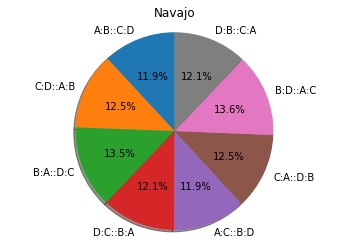

In [4]:
def is_perm(df, ids):
    return (
        (df["A"] == df["permutation"].apply(lambda x: x[ids[0]])) &
        (df["B"] == df["permutation"].apply(lambda x: x[ids[1]])) &
        (df["C"] == df["permutation"].apply(lambda x: x[ids[2]])) &
        (df["actual D"] == df["permutation"].apply(lambda x: x[ids[3]]))
    )
abcd = is_perm(df, [0,1,2,3])
cdab = is_perm(df, [2,3,0,1]) & ~abcd
badc = is_perm(df, [1,0,3,2]) & ~abcd & ~cdab
dcba = is_perm(df, [3,2,1,0]) & ~abcd & ~cdab & ~badc
acbd = is_perm(df, [0,2,1,3]) & ~abcd & ~cdab & ~badc & ~dcba
cadb = is_perm(df, [2,0,3,1]) & ~abcd & ~cdab & ~badc & ~dcba & ~acbd
bdac = is_perm(df, [1,3,0,2]) & ~abcd & ~cdab & ~badc & ~dcba & ~acbd & ~cadb
dbca = is_perm(df, [3,1,2,0]) & ~abcd & ~cdab & ~badc & ~dcba & ~acbd & ~cadb & ~bdac

perms = [abcd, cdab, badc, dcba, acbd, cadb, bdac, dbca]
labels = [a+":"+b+"::"+c+":"+d for a,b,c,d in enrich(*"ABCD")]
df_ = pd.DataFrame({label: perm for label, perm in zip(labels, perms)})
df = pd.concat([df, df_], axis=1)

sizes = [abcd.mean(), cdab.mean(), badc.mean(), dcba.mean(), acbd.mean(), cadb.mean(), bdac.mean(), dbca.mean()]
labels = [a+":"+b+"::"+c+":"+d for a,b,c,d in enrich(*"ABCD")]
explode = [0]*8

import matplotlib.pyplot as plt
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
#plt.title(f"Portion of each permutation in the mistakes of model {version} of {language.capitalize()}")
plt.title(language.capitalize())
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig(f"../0_ret-full-2016/logs/ret/2016/{language}/relative_shuffle/version_{version}/fails+.png", facecolor='w')
sum(sizes)

In [5]:

abab = is_perm(df, [0,1,0,1]) | is_perm(df, [1,0,1,0])
aabb = is_perm(df, [1,1,0,0]) | is_perm(df, [0,0,1,1])

abab.mean(), aabb.mean()

(0.0013818027210884354, 0.0014349489795918368)

1.0

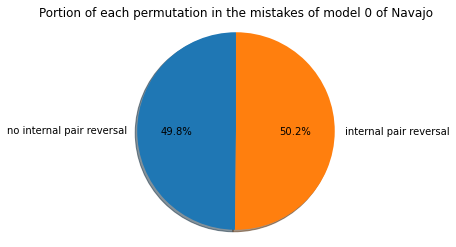

In [6]:
sizes_ = [abcd.mean() + cdab.mean() + acbd.mean() + bdac.mean(), badc.mean() + dcba.mean() + cadb.mean() + dbca.mean()]
labels_ = ["no internal pair reversal", "internal pair reversal"]
explode_ = [0]*2

fig1, ax1 = plt.subplots()
ax1.pie(sizes_, explode=explode_, labels=labels_, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title(f"Portion of each permutation in the mistakes of model {version} of {language.capitalize()}")
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
sum(sizes_)

0.9999999999999999

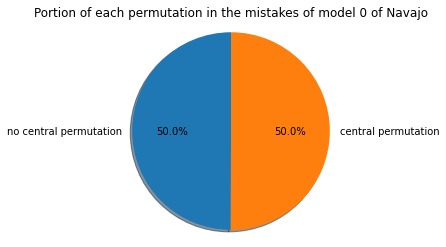

In [7]:
sizes_ = [abcd.mean() + cdab.mean() + badc.mean() + dcba.mean(), acbd.mean() + bdac.mean() + cadb.mean() + dbca.mean()]
labels_ = ["no central permutation", "central permutation"]
explode_ = [0]*2

fig1, ax1 = plt.subplots()
ax1.pie(sizes_, explode=explode_, labels=labels_, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title(f"Portion of each permutation in the mistakes of model {version} of {language.capitalize()}")
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
sum(sizes_)

<ipython-input-8-f8d7d23ec973>:6: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax1.pie(sizes_, explode=explode_, labels=labels_, autopct='%1.1f%%',


0.4995748299319728

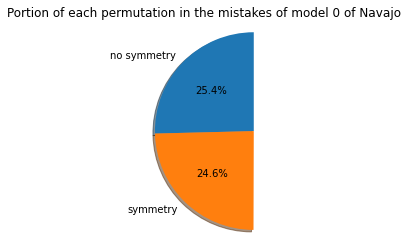

In [8]:
sizes_ = [abcd.mean() + badc.mean(), cdab.mean() + dcba.mean(), acbd.mean() + cadb.mean(), bdac.mean() + dbca.mean()][:2]
labels_ = ["no symmetry", "symmetry"]
explode_ = [0]*2

fig1, ax1 = plt.subplots()
ax1.pie(sizes_, explode=explode_, labels=labels_, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title(f"Portion of each permutation in the mistakes of model {version} of {language.capitalize()}")
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
sum(sizes_)

In [9]:
len(df["permutation"].unique())/len(df["permutation"])

0.1984481292517007

,A
count,3734.0000
mean,5.0391
std,2.1108
min,1.0000
25%,4.0000
50%,5.0000
75%,6.0000
max,16.0000


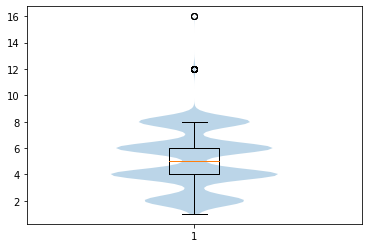

In [10]:
# amount of different permutations per failed form

plt.violinplot(df[["permutation", "A"]].groupby("permutation").aggregate(len), showextrema=False)
plt.boxplot(df[["permutation", "A"]].groupby("permutation").aggregate(len))
df[["permutation", "A"]].groupby("permutation").aggregate(len).describe()

(array([   0.,   30.,  664.,   44., 1114.,   51., 1041.,   31.,  742.,
           0.,    0.,    0.,   14.,    0.,    0.,    0.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5]),
 <BarContainer object of 16 artists>)

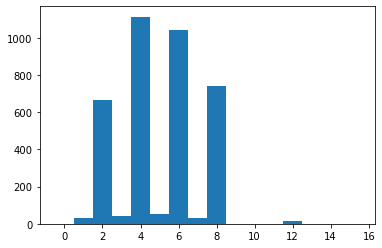

In [11]:
plt.hist(df[["permutation", "A"]].groupby("permutation").aggregate(len),bins=[i-0.5 for i in range(17)])

In [12]:

spread = df[["permutation"]+labels].groupby("permutation").aggregate(any)
spread

,A:B::C:D,C:D::A:B,B:A::D:C,D:C::B:A,A:C::B:D,C:A::D:B,B:D::A:C,D:B::C:A
permutation,,,,,,,,
"(abeʼ, neʼabeʼ, akʼah, nikʼah)",True,False,False,False,False,False,False,False
"(abeʼ, neʼabeʼ, kin, nikin)",False,False,True,False,False,False,True,False
"(abeʼ, neʼabeʼ, sáanii, nizáanii)",True,True,True,True,True,True,True,True
"(abid, nihibid, bíniʼ, nihíniʼ)",False,False,True,False,False,False,True,False
"(abid, nihibid, habid, nihibid)",False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...
"(łįįʼ, nihilįįʼ, adoh, nihidoh)",True,False,True,False,True,False,True,False
"(łįįʼ, nihilįįʼ, bíniʼ, nihíniʼ)",True,False,True,False,True,False,True,False
"(łįįʼ, nihilįįʼ, habid, nihibid)",False,False,True,False,False,False,True,False


In [259]:
df[labels].sum()

A:B::C:D    2240
C:D::A:B    2353
B:A::D:C    2539
D:C::B:A    2268
A:C::B:D    2234
C:A::D:B    2358
B:D::A:C    2550
D:B::C:A    2274
dtype: int64

In [260]:
df["feature"].describe()

count                  18816
unique                    30
top       pos=N,per=1,num=SG
freq                    3127
Name: feature, dtype: object

Text(0.5, 1.0, 'Navajo (30 of 35 features involved)')

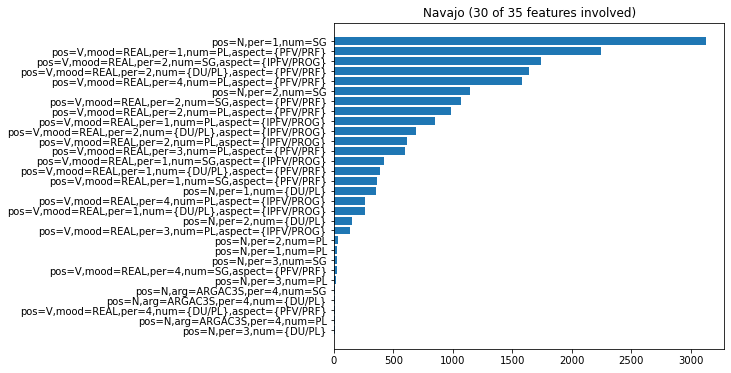

In [261]:
feature_count = df[["feature", "A"]].groupby("feature").count()
feature_count = feature_count.sort_values("A", ascending=True)

train_loader, val_loader, test_loader, encoder = prepare_data("2016", language, 50000, 5000, 5000, 512, False, split_seed=MODEL_RANDOM_SEEDS[version])

plt.figure(figsize=(7,6))
plt.barh(feature_count.index, feature_count["A"])
plt.title(language.capitalize() + f" ({len(feature_count)} of {len(test_loader.dataset.dataset.features_with_analogies)} features involved)")
#plt.xticks(rotation=90)

In [262]:
len(test_loader.dataset.dataset.features_with_analogies)

35

In [263]:
df[df["feature"]=="pos=N,per=1,num=SG"][["A", "B", "C", "actual D", "predicted D"]]

,A,B,C,actual D,predicted D
9,ajáád,shijáád,atsooʼ,sitsooʼ,atsooʼ
17,hákʼaʼí,shíkʼaʼí,bigaan,shigaan,bigaan
25,azází,shizází,ééʼ,shiʼééʼ,shizééʼ
30,agaan,shigaan,adeezhí,shideezhí,adeezhí
32,sęęs,shizęęs,bílaʼ,shílaʼ,bílaʼ
...,...,...,...,...,...
18794,shighaaʼ,shigaan,bighaaʼ,agaan,bigaan
18797,shighaaʼ,shighaaʼ,aghaaʼ,bighaaʼ,aghaaʼ
18799,shíkʼaʼí,shibid,hákʼaʼí,abid,habid
18803,shikąʼ,shiʼééʼ,shikąʼ,ééʼ,shiʼééʼ


In [264]:
z = df[df["feature"]==feature_count.index[-1]][["A", "B", "C", "actual D", "predicted D"]].iloc[:10]
text = z.to_latex(index=False)
text = text.replace("\$", "$").replace("\\textbackslash ","\\").replace("\\{", "{").replace("\\}", "}").replace("\\_", "_")
print(text)

\begin{tabular}{lllll}
\toprule
      A &        B &        C &  actual D & predicted D \\
\midrule
  ajáád &  shijáád &   atsooʼ &   sitsooʼ &      atsooʼ \\
hákʼaʼí & shíkʼaʼí &   bigaan &   shigaan &      bigaan \\
  azází &  shizází &      ééʼ &   shiʼééʼ &     shizééʼ \\
  agaan &  shigaan &  adeezhí & shideezhí &     adeezhí \\
   sęęs &  shizęęs &    bílaʼ &    shílaʼ &       bílaʼ \\
 bijáád &  shijáád &  atsʼíís &  sitsʼíís &     atsʼíís \\
 hajáád &  shijáád &    atʼaʼ &   shitʼaʼ &       atʼaʼ \\
 hagaan &  shigaan &     akąʼ &    shikąʼ &        akąʼ \\
bighaaʼ & shighaaʼ & hatłʼaaʼ & shitłʼaaʼ &    hatłʼaaʼ \\
  bílaʼ &   shílaʼ &     hééł &   shiyéél &        hééł \\
\bottomrule
\end{tabular}



In [265]:
(z["A"]==z["B"]), (z["C"]==z["actual D"]), (z["C"]==z["predicted D"])

(9     False
 17    False
 25    False
 30    False
 32    False
 39    False
 41    False
 46    False
 55    False
 59    False
 dtype: bool,
 9     False
 17    False
 25    False
 30    False
 32    False
 39    False
 41    False
 46    False
 55    False
 59    False
 dtype: bool,
 9      True
 17     True
 25    False
 30     True
 32     True
 39     True
 41     True
 46     True
 55     True
 59     True
 dtype: bool)

In [266]:
#z_ = df[df["feature"]==feature_count.index[-1]][["A", "B", "C", "actual D", "predicted D"]]
z_ = df[["A", "B", "C", "actual D", "predicted D", "feature"]]
#z_[""] = ((z_["A"]==z_["B"]) == (z_["C"]==z_["predicted D"]))
z_["1"] = ((z_["A"]==z_["B"]) ^ (z_["C"]==z_["actual D"]))
z_.groupby("feature")["1"].aggregate(mean)
#z_[""].mean()

# ###########
z = z_[z_["1"]][["A", "B", "C", "actual D", "predicted D"]].iloc[:10]
text = z.to_latex(index=False)
text = text.replace("\$", "$").replace("\\textbackslash ","\\").replace("\\{", "{").replace("\\}", "}").replace("\\_", "_")
print(text)

\begin{tabular}{lllll}
\toprule
      A &       B &       C & actual D & predicted D \\
\midrule
 shikąʼ &  shikąʼ & hooghan &  shighan &     hooghan \\
 shikąʼ &  shikąʼ &   hálaʼ &   shílaʼ &       hálaʼ \\
 shikąʼ &  shikąʼ &  atsooʼ &  sitsooʼ &      atsooʼ \\
shighan & hooghan &  shikąʼ &   shikąʼ &       hakąʼ \\
 shílaʼ &   hálaʼ &  shikąʼ &   shikąʼ &       hakąʼ \\
sitsooʼ &  atsooʼ &  shikąʼ &   shikąʼ &        akąʼ \\
 shikąʼ &  shikąʼ & shighan &  hooghan &     shighan \\
 shikąʼ &  shikąʼ &  shílaʼ &    hálaʼ &      shílaʼ \\
 shikąʼ &  shikąʼ & sitsooʼ &   atsooʼ &     sitsooʼ \\
  agaan &  hagaan & shigaan &  shigaan &      hagaan \\
\bottomrule
\end{tabular}



<ipython-input-266-1a7844f24dd6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_["1"] = ((z_["A"]==z_["B"]) ^ (z_["C"]==z_["actual D"]))


In [267]:
# ###########
z_ = df[["A", "B", "C", "actual D", "predicted D", "feature"]]
z_["aabc"] = ((z_["A"]==z_["B"]) & (z_["C"]!=z_["actual D"]))
z_["abcc"] = ((z_["A"]!=z_["B"]) & (z_["C"]==z_["actual D"]))
z_["abac"] = ((z_["A"]==z_["C"]) & (z_["B"]!=z_["actual D"]))
z_["acbc"] = ((z_["A"]!=z_["C"]) & (z_["B"]==z_["actual D"]))

z_["aabc|abcc"] = ((z_["A"]==z_["B"]) ^ (z_["C"]==z_["actual D"]))
z_["abac|acbc"] = ((z_["A"]==z_["C"]) ^ (z_["B"]==z_["actual D"]))
z_["duplicate"] = z_["aabc|abcc"] | z_["abac|acbc"]
z_["^d=c"] = (~z_["duplicate"]) & (z_["C"]==z_["predicted D"])
z_["^d=b"] = (~z_["duplicate"]) & (z_["B"]==z_["predicted D"])
z_["^d=b|^d=c"] = (z_["^d=c"] | z_["^d=b"])
z_.mean(), z_[["aabc|abcc", "abac|acbc", "duplicate", "^d=c", "^d=b","^d=b|^d=c"]].sum(), language

<ipython-input-267-69ba6661e7d1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_["aabc"] = ((z_["A"]==z_["B"]) & (z_["C"]!=z_["actual D"]))
<ipython-input-267-69ba6661e7d1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_["abcc"] = ((z_["A"]!=z_["B"]) & (z_["C"]==z_["actual D"]))
<ipython-input-267-69ba6661e7d1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

(aabc         0.008131
 abcc         0.002604
 abac         0.008131
 acbc         0.002604
 aabc|abcc    0.010736
 abac|acbc    0.010736
 duplicate    0.021152
 ^d=c         0.118197
 ^d=b         0.119313
 ^d=b|^d=c    0.237511
 dtype: float64,
 aabc|abcc     202
 abac|acbc     202
 duplicate     398
 ^d=c         2224
 ^d=b         2245
 ^d=b|^d=c    4469
 dtype: int64,
 'navajo')

In [16]:
# ###########
z_ = df[["A", "B", "C", "actual D", "predicted D", "feature"]]
z_["aabc"] = ((z_["A"]==z_["B"]) & (z_["C"]!=z_["actual D"]))
z_["abcc"] = ((z_["A"]!=z_["B"]) & (z_["C"]==z_["actual D"]))
z_["abac"] = ((z_["A"]==z_["C"]) & (z_["B"]!=z_["actual D"]))
z_["acbc"] = ((z_["A"]!=z_["C"]) & (z_["B"]==z_["actual D"]))

z_["aabc|abcc"] = ((z_["A"]==z_["B"]) ^ (z_["C"]==z_["actual D"]))
z_["abac|acbc"] = ((z_["A"]==z_["C"]) ^ (z_["B"]==z_["actual D"]))
z_["duplicate"] = z_["aabc|abcc"] | z_["abac|acbc"]
z_["^d=c"] = (~z_["duplicate"]) & (z_["C"]==z_["predicted D"])
z_["^d=b"] = (~z_["duplicate"]) & (z_["B"]==z_["predicted D"])
z_["^d=b|^d=c"] = (z_["^d=c"] | z_["^d=b"])
z_.mean(), z_[["aabc|abcc", "abac|acbc", "duplicate", "^d=c", "^d=b","^d=b|^d=c"]].sum(), language

<ipython-input-16-69ba6661e7d1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_["aabc"] = ((z_["A"]==z_["B"]) & (z_["C"]!=z_["actual D"]))
<ipython-input-16-69ba6661e7d1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_["abcc"] = ((z_["A"]!=z_["B"]) & (z_["C"]==z_["actual D"]))
<ipython-input-16-69ba6661e7d1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

(aabc         0.008131
 abcc         0.002604
 abac         0.008131
 acbc         0.002604
 aabc|abcc    0.010736
 abac|acbc    0.010736
 duplicate    0.021152
 ^d=c         0.118197
 ^d=b         0.119313
 ^d=b|^d=c    0.237511
 dtype: float64,
 aabc|abcc     202
 abac|acbc     202
 duplicate     398
 ^d=c         2224
 ^d=b         2245
 ^d=b|^d=c    4469
 dtype: int64,
 'navajo')

In [180]:
z = df[["A", "B", "C", "actual D", "predicted D"]].iloc[:10]
text = z.to_latex(index=False)
text = text.replace("\$", "$").replace("\\textbackslash ","\\").replace("\\{", "{").replace("\\}", "}").replace("\\_", "_")
print(text)

\begin{tabular}{lllll}
\toprule
          A &            B &          C &     actual D & predicted D \\
\midrule
     hataał &      hohtaał &   achʼiish &    ohchʼiish &    achʼiish \\
    yiigááh &     deiigaii &    honiłné &   dahoneelná &   dahonołné \\
    neijaah & nidashiijaaʼ &    yiʼeesh & dashiitʼeezh &  deizhʼeezh \\
      yigan &     dajizgan &   yiichííh &   dajiichiiʼ &  dajiichííh \\
      achįʼ & daʼshiichąąʼ & yiyiiłgąsh &  dashiilgąsh &  dayiiłgąsh \\
   yiiltééh &     woołteeʼ &    yiłteeh &       woołtį &    woołteeʼ \\
    yilghał &     yiilghal &    yiłmáás &     yiilmááz &     yiłmáás \\
chʼínéísííd &  chʼéénoosid &    yiłteeh &       woołtį &     wołteeh \\
   hashkeeh &  hoshoohkeed &   yidleesh &   shoodléézh &   wohdleesh \\
      ajáád &      shijáád &     atsooʼ &      sitsooʼ &      atsooʼ \\
\bottomrule
\end{tabular}



In [197]:
feature_count.index[-1]

'pos=ADJ,case=VOC'

In [19]:
feature_count = df[["feature", "A"]].groupby("feature").count()
feature_count = feature_count.sort_values("A", ascending=True)
n = df["A"].count()
df_no_d = df[~z_["duplicate"]]
df[df["feature"].str.contains("pos=V")]["A"].count()/n, df_no_d[df_no_d["feature"].str.contains("pos=V")]["A"].count()/df_no_d["A"].count(), df_no_d["A"].count()/n, (df_no_d["A"].count()-df_no_d[df_no_d["feature"].str.contains("pos=V")]["A"].count())/n

(0.7378826530612245,
 0.7535020089043327,
 0.9788477891156463,
 0.2412840136054422)

In [26]:
df_no_d_no_v = df_no_d[~df_no_d["feature"].str.contains("pos=V")]
df_no_d_no_v.groupby("feature")["A"].count()

feature
pos=N,per=1,num=PL           24
pos=N,per=1,num=SG         2849
pos=N,per=1,num={DU/PL}     342
pos=N,per=2,num=PL           28
pos=N,per=2,num=SG         1123
pos=N,per=2,num={DU/PL}     144
pos=N,per=3,num=PL           18
pos=N,per=3,num=SG           12
Name: A, dtype: int64

In [27]:
(
    df_no_d_no_v["A"].count() - 
    (
        (df_no_d_no_v["feature"] == "pos=N,per=1,num=SG").sum() +
        (df_no_d_no_v["feature"] == "pos=N,per=2,num=SG").sum()
    )
) / n, (
    (
        (df_no_d_no_v["feature"] == "pos=N,per=1,num=SG").sum() +
        (df_no_d_no_v["feature"] == "pos=N,per=2,num=SG").sum()
    )
) / n

(0.03018707482993197, 0.2110969387755102)

In [29]:
df_no_d_no_v[df_no_d_no_v["feature"] == "pos=N,per=1,num=SG"]

,Unnamed: 0,predicted D,target D,actual D,A,B,C,i,j,feature,permutation,A:B::C:D,C:D::A:B,B:A::D:C,D:C::B:A,A:C::B:D,C:A::D:B,B:D::A:C,D:B::C:A
9,9,atsooʼ,sitsooʼ,sitsooʼ,ajáád,shijáád,atsooʼ,355,374,"pos=N,per=1,num=SG","(ajáád, shijáád, atsooʼ, sitsooʼ)",True,False,False,False,False,False,False,False
17,17,bigaan,shigaan,shigaan,hákʼaʼí,shíkʼaʼí,bigaan,86,283,"pos=N,per=1,num=SG","(hákʼaʼí, shíkʼaʼí, bigaan, shigaan)",True,False,False,False,False,False,False,False
25,25,shizééʼ,shiʼééʼ,shiʼééʼ,azází,shizází,ééʼ,222,415,"pos=N,per=1,num=SG","(azází, shizází, ééʼ, shiʼééʼ)",True,False,False,False,False,False,False,False
30,30,adeezhí,shideezhí,shideezhí,agaan,shigaan,adeezhí,151,195,"pos=N,per=1,num=SG","(agaan, shigaan, adeezhí, shideezhí)",True,False,False,False,False,False,False,False
32,32,bílaʼ,shílaʼ,shílaʼ,sęęs,shizęęs,bílaʼ,201,210,"pos=N,per=1,num=SG","(sęęs, shizęęs, bílaʼ, shílaʼ)",True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18786,18786,agaan,hooghan,hooghan,shitaaʼ,shighan,ataaʼ,243,310,"pos=N,per=1,num=SG","(hooghan, shighan, ataaʼ, shitaaʼ)",False,False,False,False,False,False,False,True
18791,18791,agaan,hagaan,hagaan,sitsʼos,shigaan,atsʼos,15,337,"pos=N,per=1,num=SG","(hagaan, shigaan, atsʼos, sitsʼos)",False,False,False,False,False,False,False,True
18793,18793,atsʼíís,hatsʼíís,hatsʼíís,sitsooʼ,sitsʼíís,atsooʼ,329,374,"pos=N,per=1,num=SG","(hatsʼíís, sitsʼíís, atsooʼ, sitsooʼ)",False,False,False,False,False,False,False,True
18794,18794,bigaan,agaan,agaan,shighaaʼ,shigaan,bighaaʼ,151,396,"pos=N,per=1,num=SG","(agaan, shigaan, bighaaʼ, shighaaʼ)",False,False,False,False,False,False,False,True


In [30]:
df_no_d_no_v[df_no_d_no_v["feature"] == "pos=N,per=2,num=SG"]

,Unnamed: 0,predicted D,target D,actual D,A,B,C,i,j,feature,permutation,A:B::C:D,C:D::A:B,B:A::D:C,D:C::B:A,A:C::B:D,C:A::D:B,B:D::A:C,D:B::C:A
15,15,nidayiisniiʼ,nizáanii,nizáanii,anááʼ,ninááʼ,sáanii,39,445,"pos=N,per=2,num=SG","(anááʼ, ninááʼ, sáanii, nizáanii)",True,False,False,False,False,False,False,False
26,26,nihichʼoozhlaaʼ,nichʼoozhlaaʼ,nichʼoozhlaaʼ,séí,nizéí,hachʼoozhlaaʼ,34,304,"pos=N,per=2,num=SG","(séí, nizéí, hachʼoozhlaaʼ, nichʼoozhlaaʼ)",True,False,False,False,False,False,False,False
90,90,nisííd,nizáanii,nizáanii,achʼííʼ,nichʼííʼ,sáanii,388,445,"pos=N,per=2,num=SG","(achʼííʼ, nichʼííʼ, sáanii, nizáanii)",True,False,False,False,False,False,False,False
130,130,nihichʼoozhlaaʼ,nichʼoozhlaaʼ,nichʼoozhlaaʼ,ákʼaʼí,níkʼaʼí,hachʼoozhlaaʼ,172,304,"pos=N,per=2,num=SG","(ákʼaʼí, níkʼaʼí, hachʼoozhlaaʼ, nichʼoozhlaaʼ)",True,False,False,False,False,False,False,False
143,143,nihínííʼ,nizáanii,nizáanii,bízhiʼ,nízhiʼ,sáanii,262,445,"pos=N,per=2,num=SG","(bízhiʼ, nízhiʼ, sáanii, nizáanii)",True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18781,18781,azéí,séí,séí,nichʼííʼ,nizéí,achʼííʼ,34,388,"pos=N,per=2,num=SG","(séí, nizéí, achʼííʼ, nichʼííʼ)",False,False,False,False,False,False,False,True
18790,18790,yigąąstsiin,agąąstsiin,agąąstsiin,nibeeldléí,nigąąstsiin,beeldléí,54,384,"pos=N,per=2,num=SG","(agąąstsiin, nigąąstsiin, beeldléí, nibeeldléí)",False,False,False,False,False,False,False,True
18798,18798,níkʼaʼí,hákʼaʼí,hákʼaʼí,nizáanii,níkʼaʼí,sáanii,85,445,"pos=N,per=2,num=SG","(hákʼaʼí, níkʼaʼí, sáanii, nizáanii)",False,False,False,False,False,False,False,True
18800,18800,azéí,séí,séí,nitaaʼ,nizéí,ataaʼ,34,230,"pos=N,per=2,num=SG","(séí, nizéí, ataaʼ, nitaaʼ)",False,False,False,False,False,False,False,True
